In [1]:
!pip install -q transformers nltk tensorflow tensorflow-hub tensorflow_text

In [2]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# train_prompt_file = "/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv"
# df_train_prompt = pd.read_csv(train_prompt_file)

# train_essay_file = "/kaggle/input/llm-detect-ai-generated-text/train_essays.csv"
# df_train_essay = pd.read_csv(train_essay_file)

test_essay_file = "/kaggle/input/llm-detect-ai-generated-text/test_essays.csv"
# train_ex = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
df_test_essay = pd.read_csv(test_essay_file)

# sub_file = "/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv"
# df_sub = pd.read_csv(sub_file)

In [4]:
# df_train_essay.head()

In [5]:
# df_train_prompt.head()

In [6]:
# df_train_essay.info()

In [7]:
# df_train_essay["generated"].value_counts()

In [8]:
# sns.countplot(x=df_train_essay['generated'])
# plt.show

In [9]:
# df_train_essay["prompt_id"].value_counts()

In [10]:
# sns.countplot(x=df_train_essay['prompt_id'])
# plt.show

In [11]:
train_essay_ex_file = "/kaggle/input/daigt-v2-train-dataset/train_v2_drcat_02.csv"
# train_essay_ex2_file = "/kaggle/input/llm-7-prompt-training-dataset/train_essays_RDizzl3_seven_v1.csv"
df_train_essay_ex = pd.read_csv(train_essay_ex_file)
# df_train_essay_ex2 = pd.read_csv(train_essay_ex2_file)

In [12]:
df_train_essay_ex_ = df_train_essay_ex[df_train_essay_ex.RDizzl3_seven == False].reset_index(drop=True)
df_train_essay_ex_ = df_train_essay_ex[df_train_essay_ex["label"]==1].sample(8000)
df_train_essay_ex = df_train_essay_ex[df_train_essay_ex.RDizzl3_seven == True].reset_index(drop=True)
df_train_essay_ex = pd.concat([df_train_essay_ex, df_train_essay_ex_])
df_train_essay_ex['text'] = df_train_essay_ex['text'].str.replace('\n', '')
df_test_essay['text'] = df_test_essay['text'].str.replace('\n', '')
# df_train_essay_ex['label'].value_counts()

In [13]:
# df_train_essay_ex.rename(columns = {"label":"generated"}, inplace=True)
df_train_essay_ex['label'].value_counts()

label
0    14250
1    14200
Name: count, dtype: int64

In [14]:
# train_ex.rename(columns={'generated':'label'}, inplace= True)
# train_ex

In [15]:
# df_train_essay_ex2['label'].value_counts()

<function matplotlib.pyplot.show(close=None, block=None)>

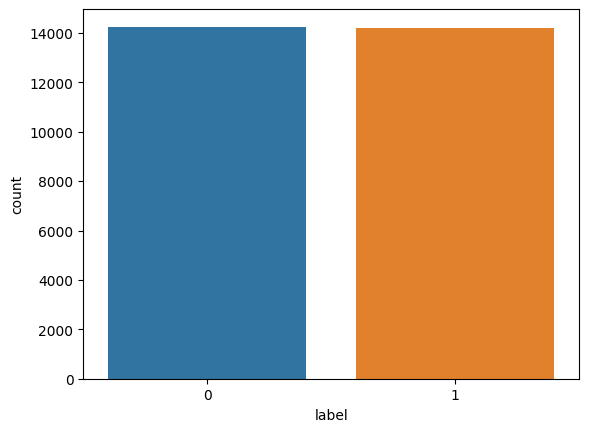

In [16]:
sns.countplot(x=df_train_essay_ex['label'])
plt.show

In [17]:
# sns.countplot(x=df_train_essay_ex2['label'])
# plt.show

In [18]:
# df_train = pd.concat([df_train_essay_ex[["text", "label"]],
#                                    df_train_essay_ex2[["text", "label"]]])
# df_train = pd.concat([df_train_essay_ex[["text", "label"]],
#                                    train_ex[["text", "label"]]])
df_train = df_train_essay_ex[["text", "label"]]
df_train

,text,label
0,Cars have been around for awhile and they have...,0
1,Have you ever thought what it would be like no...,0
2,What you are about to read is going to give yo...,0
3,cars have many flaws nd and in this day and ag...,0
4,There are many advantages of limiting car usag...,0
...,...,...
33452,"Standardized testing is dumb. I mean, whats th...",1
37485,"While Driverless Cars May Provide Convenience,...",1
34835,"Hey, so I'm gonna write this essay about the p...",1
34867,Title: The Importance of a Research Checklist ...,1


In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28450 entries, 0 to 29409
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28450 non-null  object
 1   label   28450 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 666.8+ KB


In [20]:
df_train['label'].value_counts()

label
0    14250
1    14200
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

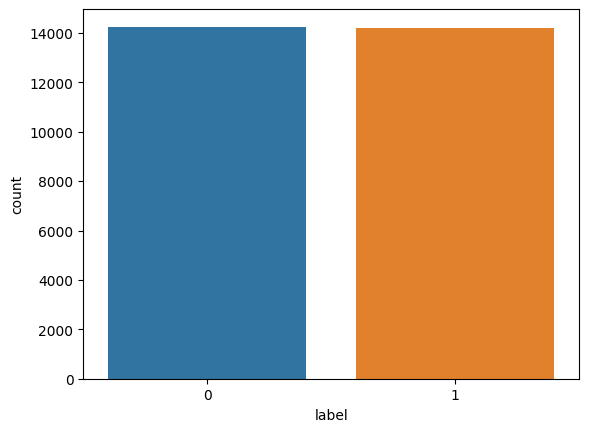

In [21]:
sns.countplot(x=df_train['label'])
plt.show

In [22]:
# # Function to balance label counts
# def undersample(df, label_column='generated'):
#     label_counts = df[label_column].value_counts()
#     min_count = label_counts.min()

#     balanced_df = pd.DataFrame()

#     for label, count in label_counts.items():
#         label_subset = df[df[label_column] == label]
#         undersampled_subset = label_subset.sample(n=min_count, random_state=42)
#         balanced_df = pd.concat([balanced_df, undersampled_subset], ignore_index=True)

#     return balanced_df

# # Balance labels in the DataFrame
# df_balanced_train = undersample(df_train)

# Print the balanced DataFrame
# print(df_balanced_train)

<function matplotlib.pyplot.show(close=None, block=None)>

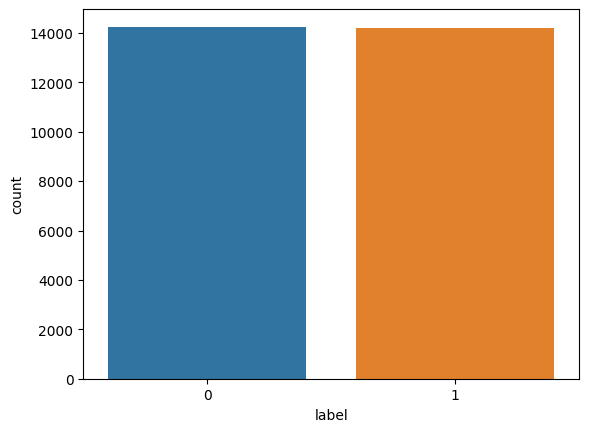

In [23]:
sns.countplot(x=df_train['label'])
plt.show

In [24]:
df_train["text_len"] = df_train["text"].apply(lambda x : len(x.split()))

/tmp/ipykernel_27/2420977747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["text_len"] = df_train["text"].apply(lambda x : len(x.split()))


In [25]:
df_train

,text,label,text_len
0,Cars have been around for awhile and they have...,0,533
1,Have you ever thought what it would be like no...,0,212
2,What you are about to read is going to give yo...,0,613
3,cars have many flaws nd and in this day and ag...,0,188
4,There are many advantages of limiting car usag...,0,311
...,...,...,...
33452,"Standardized testing is dumb. I mean, whats th...",1,271
37485,"While Driverless Cars May Provide Convenience,...",1,356
34835,"Hey, so I'm gonna write this essay about the p...",1,373
34867,Title: The Importance of a Research Checklist ...,1,354


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


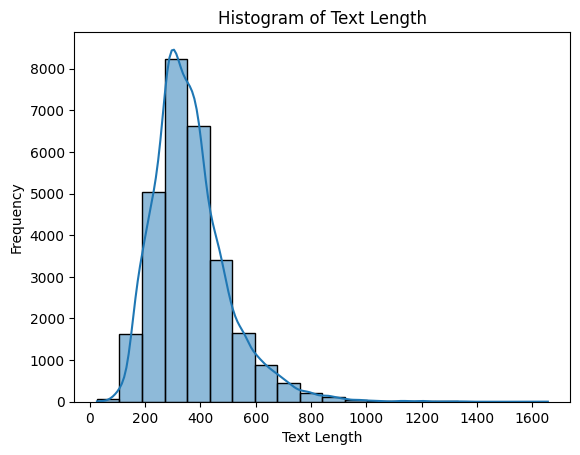

In [26]:
sns.histplot(df_train['text_len'], bins=20, kde=True)
plt.title('Histogram of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [27]:
print(df_train["text_len"].mean())
print(df_train["text_len"].max())

364.0258699472759
1656


In [28]:
def remove_stopwords(input_text, language='english'):
    """
    Remove stopwords from the input text.

    Parameters:
    - input_text (str): The input text containing stopwords.
    - language (str): The language of the stopwords. Default is 'english'.

    Returns:
    - str: The cleaned text without stopwords.
    """
    # Tokenize the text
    words = word_tokenize(input_text['text'])
    
    print(f"Index {input_text['index_col']}") if input_text['index_col'] % 10000 == 0 else None

#     Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stopwords.words(language)]

    # Join the filtered words to form the cleaned text
    cleaned_text = ' '.join(filtered_words)

    return cleaned_text

In [29]:
# df_balanced_train['index_col'] = df_balanced_train.index
# df_balanced_train["text"] = df_balanced_train.apply(lambda text: remove_stopwords(text), axis=1)

df_train['index_col'] = df_train.index
df_train['text'] = df_train.apply(lambda text: remove_stopwords(text), axis=1)

df_test_essay['index_col'] = df_test_essay.index
df_test_essay["text"] = df_test_essay.apply(lambda text: remove_stopwords(text), axis=1)

/tmp/ipykernel_27/4145976751.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index_col'] = df_train.index


Index 0
Index 10000
Index 20000
Index 40000
Index 30000
Index 0


/tmp/ipykernel_27/4145976751.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['text'] = df_train.apply(lambda text: remove_stopwords(text), axis=1)


In [30]:
x, y = df_train['text'], df_train['label']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42, stratify=y)


In [32]:
model_path = "/kaggle/input/bert/tensorflow2/bert-en-uncased-l-12-h-128-a-2/2"
preprocess_path = "/kaggle/input/bert/tensorflow2/en-uncased-preprocess/3/"

In [33]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer(preprocess_path)
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer(
    model_path,
    trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]      # [batch_size, 512].
sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 512].
dense_1 = tf.keras.layers.Dense(128 , activation='relu')(pooled_output)
dropout = tf.keras.layers.Dropout(0.7 , name="dropout1")(pooled_output)
dense_2 = tf.keras.layers.Dense(64 , activation='relu')(dropout)
dropout = tf.keras.layers.Dropout(0.5 , name="dropout2")(dense_2)

dense_out = tf.keras.layers.Dense(1 , activation='sigmoid', name='output')(dropout)


model = tf.keras.Model(inputs=text_input, outputs=dense_out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [34]:
# https://huggingface.co/google/bert_uncased_L-12_H-128_A-2
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=["acc"])

checkpoint_filepath = 'checkpoint.hdf5'
metric = 'val_accuracy'
callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                    monitor=metric,
                                                    verbose=2,
                                                    save_best_only=True,
                                                    mode='max'), 
                 tf.keras.callbacks.EarlyStopping(monitor=metric,
                                                  patience=0,
                                                  restore_best_weights=True)
                ]
history = model.fit(x_train, y_train , batch_size=8, callbacks=[callback_list],
                    epochs=5 , validation_data=(x_test, y_test))
# model.load_weights(checkpoint_filepath)
model.save("model-bert")

Epoch 1/5
2845/2845 [==============================] - 240s 68ms/step - loss: 0.1972 - acc: 0.9250 - val_loss: 0.0650 - val_acc: 0.9815
Epoch 2/5
2845/2845 [==============================] - 156s 55ms/step - loss: 0.0423 - acc: 0.9885 - val_loss: 0.0181 - val_acc: 0.9928
Epoch 3/5
2845/2845 [==============================] - 156s 55ms/step - loss: 0.0230 - acc: 0.9936 - val_loss: 0.0196 - val_acc: 0.9958
Epoch 4/5
2845/2845 [==============================] - 155s 54ms/step - loss: 0.0112 - acc: 0.9963 - val_loss: 0.0085 - val_acc: 0.9972
Epoch 5/5
2845/2845 [==============================] - 151s 53ms/step - loss: 0.0074 - acc: 0.9983 - val_loss: 0.0175 - val_acc: 0.9965


# Test

In [35]:
loss , acc = model.evaluate(x_train, y_train)
print("Accuracy on Train data:",acc)
loss , acc = model.evaluate(x_test, y_test)
print("Accuracy on Test data:",acc)

712/712 [==============================] - 59s 82ms/step - loss: 9.9250e-04 - acc: 0.9996
Accuracy on Train data: 0.9995606541633606
178/178 [==============================] - 15s 85ms/step - loss: 0.0175 - acc: 0.9965
Accuracy on Test data: 0.9964850544929504


In [36]:
y_pred = model.predict(x_test)
y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]
print(roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(f1_score(y_test, y_pred, average='macro'))


178/178 [==============================] - 15s 79ms/step
0.9964881393624907
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2850
           1       0.99      1.00      1.00      2840

    accuracy                           1.00      5690
   macro avg       1.00      1.00      1.00      5690
weighted avg       1.00      1.00      1.00      5690

0.9964850615114236
0.9982394366197183
0.9947368421052631
0.9964850615114235


In [37]:
y_pred = model.predict(df_test_essay['text'])
y_pred

1/1 [==============================] - 0s 30ms/step


array([[9.9999845e-01],
       [9.6398032e-01],
       [5.4714155e-06]], dtype=float32)

In [38]:
submission_data = {'id': df_test_essay['id'], 'generated': y_pred[:, 0]}
submission = pd.DataFrame(submission_data)

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

In [39]:
pd.read_csv("/kaggle/working/submission.csv")

,id,generated
0,0000aaaa,0.999998
1,1111bbbb,0.963980
2,2222cccc,0.000005


In [40]:
print('done')

done
